In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cleaning_fun as cfun
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import ogr,csv,sys
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
cle = cfun.cleaner()

%reload_ext autoreload
%autoreload 2

In [2]:
data1 = pd.read_csv("data1.csv")

# "abb14" () is droped due to their NaN values
data1.drop(["Unnamed: 0", "abb14"], axis = 1, inplace = True)
# Fill missing values in "last entrance" with subscription purchase date.
# This because all IDs that do not have a last entrance, actually never used the card (check below)
data1["ultimo_ing.x"].fillna(data1["abb13"], inplace = True)

# Add a column that is the interval between last entrance date and subscription purchase date.
# It may be useful because this time window identifies those that can be really interested in museums
# (e.g. small span -> used the card immediately because of immediate purchase, then forgot about it)
data1["span.utilizzo"] = [x.days for x in pd.to_datetime(data1["ultimo_ing.x"]) - pd.to_datetime(data1["abb13"])]

# Convert the target variable to categorical
data1["si2014"] = pd.Categorical(data1["si2014"])
data1.head()

,codcliente,si2014,ultimo_ing.x,abb13,span.utilizzo
0,100005,0,2013-09-19,2013-01-27,235
1,100006,1,2013-11-21,2013-01-14,311
2,100007,0,2012-12-05,2012-12-05,0
3,100017,1,2013-10-19,2012-12-10,313
4,100020,0,2013-08-11,2012-12-09,245


In [3]:
an13 = pd.read_csv("an13.csv", na_values = "NA", encoding = "latin1")

# "CAP", "agenzia", "riduzione" & "sconto" have to many values to actually be useful.
# "Professione" has 100% NaN values
an13.drop(["Unnamed: 0", "professione", "sconto","riduzione", "agenzia", "cap"], axis = 1, inplace = True)

# Convert "data di nascita" into age at the end of year 2013.
# Before, it was necessary to replace 2 values that had "-" with
# the median of the overall year of birth distribution (= 1959).
median_age = pd.Series([x for x in an13["data_nascita"] if "-" not in x]).median()
an13["data_nascita"] = [int(x) if "-" not in x else int(median_age) for x in an13["data_nascita"]]
an13["age"] = an13["data_nascita"].apply(lambda x: 2013-x)

# "nuovo_abb" is alrady dichotomous and with full values. Just convert it into 0/1
an13["nuovo_abb"] = pd.Categorical(an13["nuovo_abb"].apply(lambda x: 1 if x == "NUOVO ABBONATO" else 0))

# "sesso" has missing values. We filled the according to the distribution of non-NaN values
count_sex = an13["sesso"].value_counts(normalize=True)
missing_sex = an13["sesso"].isnull()
an13.loc[an13["sesso"].isnull(),"sesso"] = np.random.choice(count_sex.index,
                                                            size = len(an13[missing_sex]),
                                                            p = count_sex.values)

# Then the 0/1 variable is created according to sex (female = 1)
an13["femmina"] = pd.Categorical(an13["sesso"].apply(lambda x: 1 if x == "F" else 0))

# Tipo_pag is converted into 4 dummies
an13 = pd.concat([an13, pd.get_dummies(an13["tipo_pag"], drop_first = True)], axis = 1)

# The following columns will then be converted into categories
an13["BANCOMAT"] = pd.Categorical(an13["BANCOMAT"])
an13["CONTANTI"] = pd.Categorical(an13["CONTANTI"])
an13["CARTA DI CREDITO"] = pd.Categorical(an13["CARTA DI CREDITO"])
an13["NESSUN PAGAMENTO"] = pd.Categorical(an13["NESSUN PAGAMENTO"])

an13.drop(["sesso","tipo_pag","data_nascita"], axis = 1, inplace = True)

In [4]:
# The following dataset, created from a .json file, is needed to
# reduce the dimensionality of the column "comune".
comunes = pd.read_excel("comuni_done.xlsx")
comunes.drop(["Unnamed: 0", "codice","zona__codice","zona__nome",
              "regione__codice","regione__nome","provincia__codice","provincia__nome",
              "codiceCatastale", "popolazione"], axis = 1, inplace = True)
comunes["nome"] = comunes["nome"].str.upper()
comunes.rename({"nome": "comune"}, axis = 1, inplace = True)

# We performed a merge on the column "comune" of an13 dataframe,
# then we adjusted the result by creating a dictionary with the unmatched
# values of that column (mainly foregn countries).
an13 = an13.merge(comunes, how = "left", on = "comune")

# The following column is to replace NaN values of "sigla" according to the
# dictionary above, and eventually to reduce its dimensionality to 3
an13["sigla"] = cle.provs(an13)

# From the updated column "sigla" it was possible to create
# the dummies and attached them on the right side of an13.
an13 = pd.concat([an13, pd.get_dummies(an13["sigla"], drop_first = True)], axis = 1)
an13.drop(["comune","sigla"], axis = 1, inplace = True)

# Finally, the last column whose dimensionality needed a reduction was 
# "agenzia_tipo", that was broken down into 5 aspects based on conceptual
# clusters of the original values. Then the column is added to "an13" and dropped
an13["agenzia_tipo"] = cle.reduce_agency(an13)
an13 = pd.concat([an13, pd.get_dummies(an13["agenzia_tipo"], drop_first = True)], axis = 1)
an13.drop(["agenzia_tipo"], axis = 1, inplace = True)

# At last, we created the column of the day of the year
# in which a customer purchased their subscription.
an13["data_inizio"] = pd.to_datetime(an13["data_inizio"], format = "%d/%m/%Y %H:%M")
an13["day_y_purchase"] = [int(x.strftime('%j')) for x in an13["data_inizio"]]
an13.drop("data_inizio", axis = 1, inplace = True)

an13.rename({"importo": "prezzo_card"}, axis = 1, inplace = True)

# Convert the dummies created into categorical variables
for c in an13.columns[9:15]:
    an13[c] = pd.Categorical(an13[c])

an13.head()

,codcliente,prezzo_card,nuovo_abb,age,femmina,BANCOMAT,CARTA DI CREDITO,CONTANTI,NESSUN PAGAMENTO,cap__-,cap,PI,TO,CRAL/TESSERE ORO/ASSOCIAZIONE,MUSEO/TEATRI/EDICOLE,OFFERTE/GRUPPI,PUNTO INFORMATIVO/COMMERCIALE/NAN,day_y_purchase
0,90095,28,1,28,0,0,0,1,0,NaN,10121.0,0,1,0,0,0,1,344
1,89662,28,1,28,0,0,0,1,0,NaN,10121.0,0,1,0,0,0,1,6
2,202278,28,1,21,0,1,0,0,0,NaN,10121.0,0,1,0,0,0,1,27
3,269895,28,1,27,0,0,0,1,0,NaN,NaN,0,0,0,0,0,1,337
4,88177,28,1,30,0,0,0,1,0,NaN,10121.0,0,1,0,0,0,1,26


In [5]:
in13 = pd.read_csv("in13.csv", na_values = "NA")
in13.drop("Unnamed: 0", axis = 1, inplace = True)
# The rename will be useful in the merge of the 3 final datasets,
# while the following line is a quick string cleaning
in13.rename({"CodCliente": "codcliente"}, axis = 1, inplace = True)
in13["museo"] = [x.replace("\\","").replace('"',"") for x in in13["museo"]]

# Merge with a file that contains the type of museum per each line
un_mus = pd.read_excel("museums.xlsx")
un_mus["museo"] = [x.replace("\\","").replace('"',"") for x in un_mus["museo"]]
in13 = in13.merge(un_mus, how = "left", on = "museo")
in13.drop(["comune.museo","prov.museo"], axis = 1, inplace = True)

# Drop (actually exclude) all the rows that contain the weird "00:00" value
in13 = in13[in13['orai'] != "00:00"]

# Collapse into one column the date and time of entrance, so the timestamp is precise and unique
in13["timestamp"] = pd.to_datetime(in13["datai"] + " " + in13["orai"], format = "%d/%m/%Y %H:%M")

# Drop "day_entrance" & "time_entrance"
in13.drop(["datai", "orai"], axis = 1, inplace = True)

# Order the dataset by the timestamp
in13.sort_values(by = ["timestamp"], inplace = True)
in13.reset_index(drop = True, inplace = True)

In [6]:
# colonna 1: singoli cap dei musei (60 righe)
# colonna 2: counts

# creating the df
df_map = pd.DataFrame(in13["com_museo"].value_counts())
df_map.reset_index(level=0, inplace=True)
# changing colums' name
df_map = df_map.rename(columns={'index': 'comune', 'com_museo': 'frequenza_comparsa'})
df_map[df_map['comune']== 'TORINO (TO)' ] += df_map[df_map['comune'] == 'TORINO']
df_map['frequenza_comparsa'] = df_map['frequenza_comparsa'].values.astype(np.int64)
df_map = df_map[df_map['comune'] != 'DATO MANCANTE' ]
df_map.dropna(inplace=True)
df_map.head()

,comune,frequenza_comparsa
0,TORINO,331474
1,VENARIA REALE,119361
2,BARD,18983
4,RIVOLI,6677
5,AGLIE',6076


In [8]:
comunes = comunes.rename(columns={'cap__-' : 'IT_CAP'})
comunes.drop('cap', axis=1, inplace=True)
comunes

,comune,sigla,IT_CAP
0,ABANO TERME,PD,35031.0
1,ABBADIA CERRETO,LO,26834.0
2,ABBADIA LARIANA,LC,23821.0
3,ABBADIA SAN SALVATORE,SI,53021.0
4,ABBASANTA,OR,9071.0
...,...,...,...
8565,ZUGLIO,UD,33020.0
8566,ZUMAGLIA,BI,13848.0
8567,ZUMPANO,CS,87040.0
8568,ZUNGOLI,AV,83030.0


In [9]:
permappa = df_map.merge(comunes, how = "left", on = "comune")

,comune,frequenza_comparsa,sigla,IT_CAP
0,TORINO,331474,TO,NaN
1,VENARIA REALE,119361,TO,10078.0
2,BARD,18983,AO,11020.0
3,RIVOLI,6677,TO,10098.0
4,AGLIE',6076,NaN,NaN


In [10]:
permappa.at[0, 'IT_CAP'] = 10121
permappa.at[4, 'sigla'] = 'TO'
permappa.at[4, 'sigla'] = 'TO'
permappa.at[4, 'IT_CAP'] = 10121
permappa.at[8, 'sigla'] = 'TO'
permappa.at[8, 'IT_CAP'] = 10057
permappa.at[19, 'sigla'] = 'CN'
permappa.at[19, 'IT_CAP'] = 12100
permappa.at[34, 'sigla'] = 'TO'
permappa.at[34, 'IT_CAP'] = 10051
permappa.at[44, 'sigla'] = 'CN'
permappa.at[44, 'IT_CAP'] = 12026
permappa.at[48, 'sigla'] = 'VC'
permappa.at[48, 'IT_CAP'] = 13019
permappa.at[53, 'sigla'] = 'TO'
permappa.at[53, 'IT_CAP'] = 10082
permappa.at[54, 'IT_CAP'] = 15121

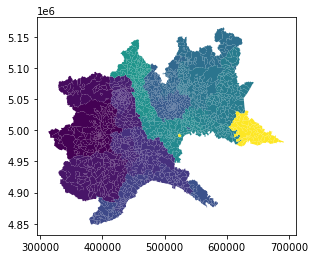

In [29]:
NO = gpd.read_file('cap_NO.shp')
NO.plot(column='IT_CAP')
plt.savefig("map_total_cap.jpg", dpi = 300)
plt.show()

In [21]:
mappa_merged = NO.merge(permappa, how = "left", on = "IT_CAP")
mappa_merged.head()

,IT_CAP,geometry,comune,frequenza_comparsa,sigla
0,10010.0,"MULTIPOLYGON (((420591.251 5035642.001, 420621...",CARAVINO,1440.0,TO
1,10011.0,"POLYGON ((405442.001 5026774.001, 405333.001 5...",NaN,NaN,NaN
2,10012.0,"POLYGON ((419476.501 5036392.501, 420111.251 5...",NaN,NaN,NaN
3,10013.0,"POLYGON ((410480.501 5043149.501, 410815.751 5...",NaN,NaN,NaN
4,10014.0,"POLYGON ((413467.251 5018753.501, 413760.251 5...",NaN,NaN,NaN


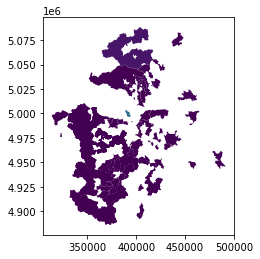

In [30]:
mappa_definitiva.plot(column='frequenza_comparsa')
plt.savefig("map_cap_frequency.jpg", dpi = 300)
plt.show()

<Figure size 3000x1800 with 0 Axes>

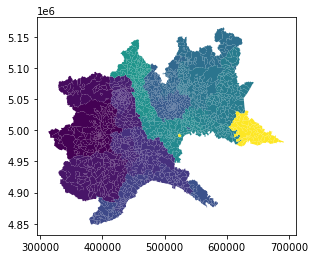

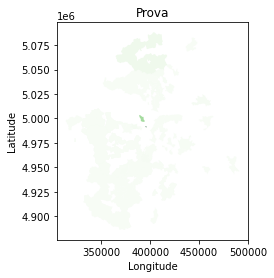

In [132]:
plt.figure(figsize=(10, 6), dpi=300)

aa = NO.plot(column='IT_CAP')
bb = mappa_definitiva.plot(column='frequenza_comparsa')

plt.title('Prova')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()